# Descreptive analysis of stratification approach

In [55]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score, train_test_split, RandomizedSearchCV, KFold, StratifiedKFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.datasets import make_friedman1
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import shuffle
import json
from sklearn.dummy import DummyRegressor
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import warnings
warnings.filterwarnings('ignore')
from utils import FriedmanDataset, create_cont_folds, fold_visualizer

In [56]:
# Data Creation
n_train= 1000
n_test= 100000
n_features = 10
FD_noise= 0
transformation='sqrt'
seed=567

# Stratification
n_groups = 20

# RandomSearchCV
n_folds = 4
n_iter= 200
n_repetitions= 10
scoring= 'neg_mean_squared_error' 
n_jobs= -1



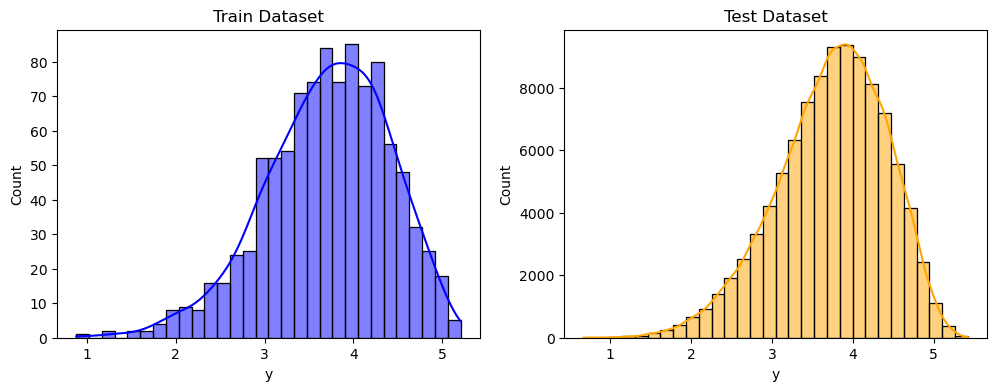

In [30]:
train = FriedmanDataset(n_samples=n_train, 
                            n_features=n_features, 
                            noise=FD_noise, 
                            random_state=seed)
train.transform(transformation=transformation)


test = FriedmanDataset(n_samples=n_test,
                           n_features=n_features,
                           noise=FD_noise,
                           random_state=seed)
test.transform(transformation=transformation)


# Show here histograms of train and train datasets
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

sns.histplot(train.df, x='y', bins=30, kde=True, ax=axes[0], color='blue')
axes[0].set_title('Train Dataset')

sns.histplot(test.df, x='y', bins=30, kde=True, ax=axes[1], color='orange')
axes[1].set_title('Test Dataset')

plt.show()

## Kolmogorov-Smirnov test (exemplary)
1. Test if train and test split come from same distribution.   
2. Test if train and exponentail data come form same distribution.

In [61]:
# 1. Test if train and test split come from same distribution.   

from scipy.stats import ks_2samp
# Perform the Kolmogorov-Smirnov test
statistic, p_value = ks_2samp(train.df['y'], test.df['y'])

# Print the results
print("K-S Statistic:", statistic)
print("P-value:", p_value)

# Interpret the results
alpha = 0.05
if p_value > alpha:
    print("Same Distributions: Fail to reject the null hypothesis. Data1 and Data2 may come from the same distribution.")
else:
    print("Differetn Distributions: Reject the null hypothesis. Data1 and Data2 likely come from different distributions.")

K-S Statistic: 0.025859999999999994
P-value: 0.5137146665586914
Same Distributions: Fail to reject the null hypothesis. Data1 and Data2 may come from the same distribution.


In [76]:
# 2. Test if train and test split come from same distribution.   
# ceate data follwing exponential distribution
from scipy.stats import expon
y_expon = expon.rvs(size=n_train, random_state=seed)

from scipy.stats import ks_2samp
# Perform the Kolmogorov-Smirnov test
statistic, p_value = ks_2samp(train.df['y'],y_expon)

# Print the results
print("K-S Statistic:", statistic)
print("P-value:", p_value)

# Interpret the results
alpha = 0.05
if p_value > alpha:
    print("Same Distributions: Fail to reject the null hypothesis. Data1 and Data2 may come from the same distribution.")
else:
    print("Differetn Distributions: Reject the null hypothesis. Data1 and Data2 likely come from different distributions.")

K-S Statistic: 0.859
P-value: 0.0
Differetn Distributions: Reject the null hypothesis. Data1 and Data2 likely come from different distributions.


## Calculate Kernel Density Estimation 

<Axes: ylabel='Count'>

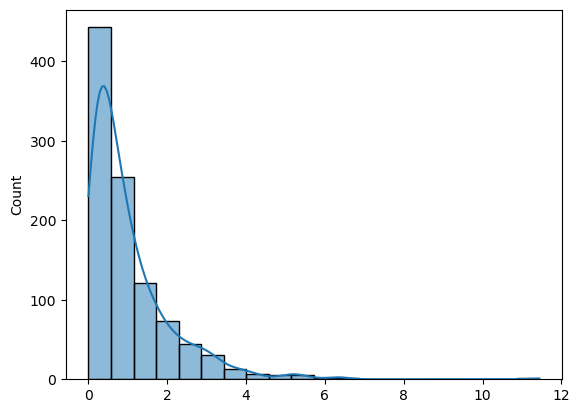

In [63]:
# Kernel Density Estimation with seaborn
sns.histplot(y_expon, bins=20, kde = True)


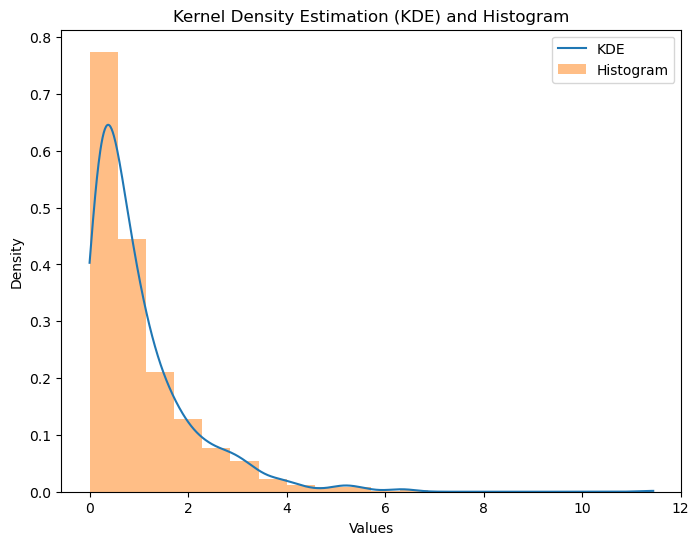

In [66]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# Calculate KDE
kde = gaussian_kde(y_expon)

# Create a range of values for the x-axis
y_expon_kde = np.linspace(min(y_expon), max(y_expon), 1000)

# Plot the KDE
plt.figure(figsize=(8, 6))
plt.plot(x_vals, kde(x_vals), label='KDE')
plt.hist(y_expon, density=True, alpha=0.5, bins=20, label='Histogram')  # Overlay with the histogram for comparison
plt.title('Kernel Density Estimation (KDE) and Histogram')
plt.xlabel('Values')
plt.ylabel('Density')
plt.legend()
plt.show()


In [67]:
import numpy as np
from scipy.integrate import trapz

# Example curves (replace with your actual data)
curve1 = y_expon_kde
curve2 = train.df['y']

# Find the common x-values
common_x = np.intersect1d(curve1, curve2)

# Interpolate to get the y-values for the common x-values
curve1_interp = np.interp(common_x, curve1, np.arange(len(curve1)))
curve2_interp = np.interp(common_x, curve2, np.arange(len(curve2)))

# Calculate the overlapping area using trapezoidal integration
overlapping_area = trapz(np.minimum(curve1_interp, curve2_interp), x=common_x)

print("Overlapping Area:", overlapping_area)


Overlapping Area: 0.0


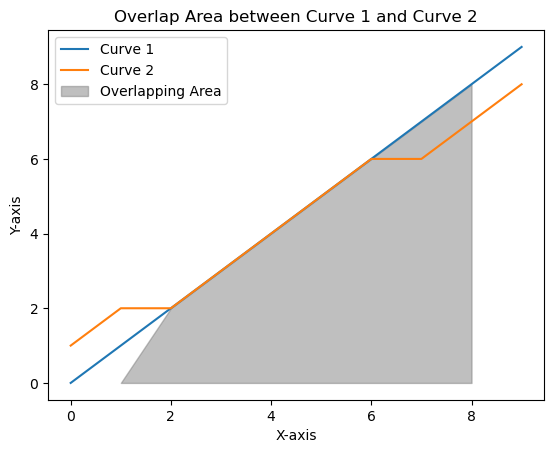

Overlapping Area: 31.0


In [68]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import trapz

# Example curves (replace with your actual data)
curve1 = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
curve2 = np.array([1, 2, 2, 3, 4, 5, 6, 6, 7, 8])

# Find the common x-values
common_x = np.intersect1d(curve1, curve2)

# Interpolate to get the y-values for the common x-values
curve1_interp = np.interp(common_x, curve1, np.arange(len(curve1)))
curve2_interp = np.interp(common_x, curve2, np.arange(len(curve2)))

# Calculate the overlapping area using trapezoidal integration
overlapping_area = trapz(np.minimum(curve1_interp, curve2_interp), x=common_x)

# Plotting
plt.plot(curve1, label='Curve 1')
plt.plot(curve2, label='Curve 2')
plt.fill_between(common_x, np.minimum(curve1_interp, curve2_interp), color='gray', alpha=0.5, label='Overlapping Area')

plt.title('Overlap Area between Curve 1 and Curve 2')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend()
plt.show()

print("Overlapping Area:", overlapping_area)


In [72]:
data.shape

(6, 4)

In [74]:
data = np.concatenate((train.df['y'], y_expon), axis=0)

ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 1 dimension(s) and the array at index 1 has 2 dimension(s)

In [ ]:
print(y_expon.shape)
print(train.df['y'].shape)

In [86]:
# concaternate train['y] and expon_y columwise
data = np.column_stack((train.df['y'], y_expon))
data.shape

(1000, 2)

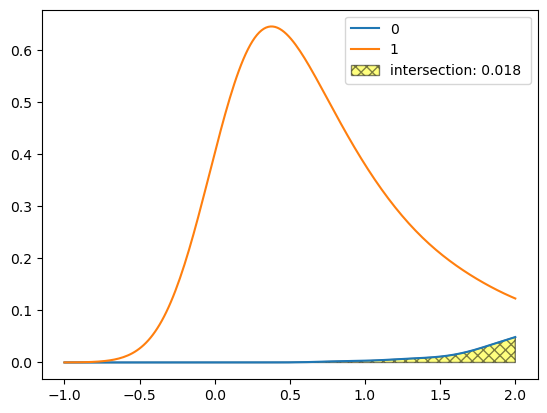

In [87]:
from matplotlib import pyplot as plt
from scipy.stats import gaussian_kde
import numpy as np

#data = np.random.rand(6, 4) ** 3
x = np.linspace(-1, 2, 200)
ys = []
for label in range(2):
    kde_func = gaussian_kde(data[:, label])
    y = kde_func(x)
    plt.plot(x, y, label=label)
    ys.append(y)
y_intersection = np.amin(ys, axis=0)
area = np.trapz(y_intersection, x)
fill_poly = plt.fill_between(x, 0, y_intersection, fc='yellow', ec='black', alpha=0.5,
                             label=f'intersection: {area:.3f} ')
fill_poly.set_hatch('xxx')
plt.legend()

## Cross-validation (random)

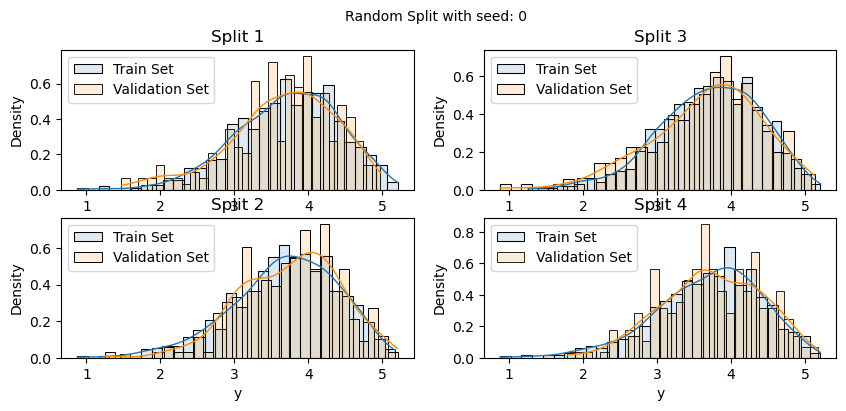

In [42]:
for i in range(1):
    cv_splits = list(KFold(n_folds, shuffle=True, random_state=i).split(train.df['y']))
    fold_visualizer(data=train.df['y'], fold_idxs=cv_splits, seed_num=i)

## Cross-validation (stratified)

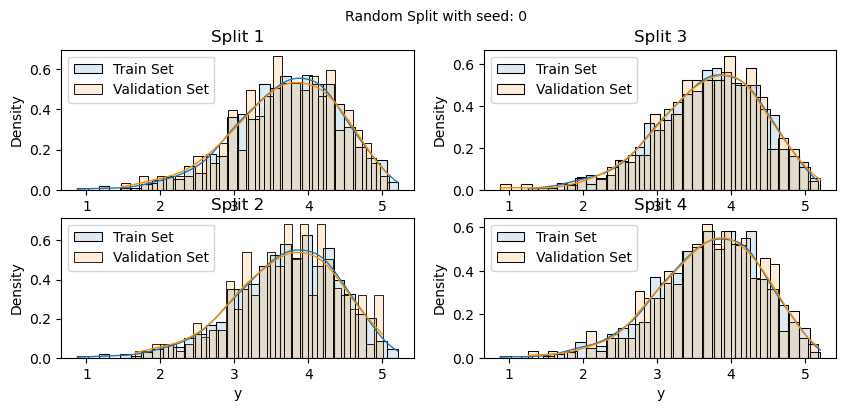

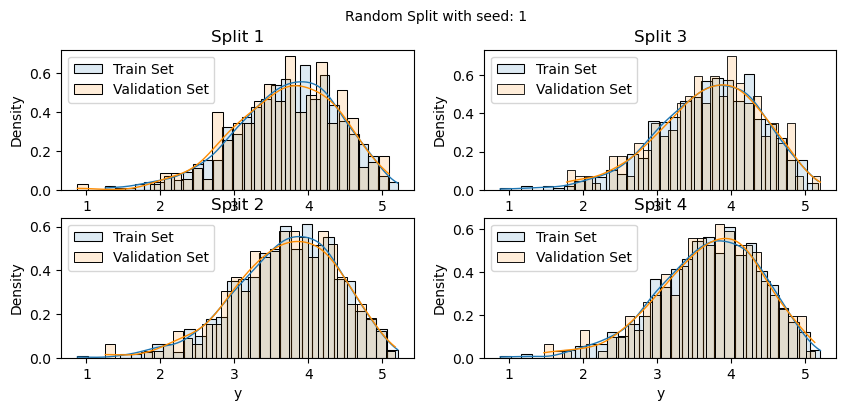

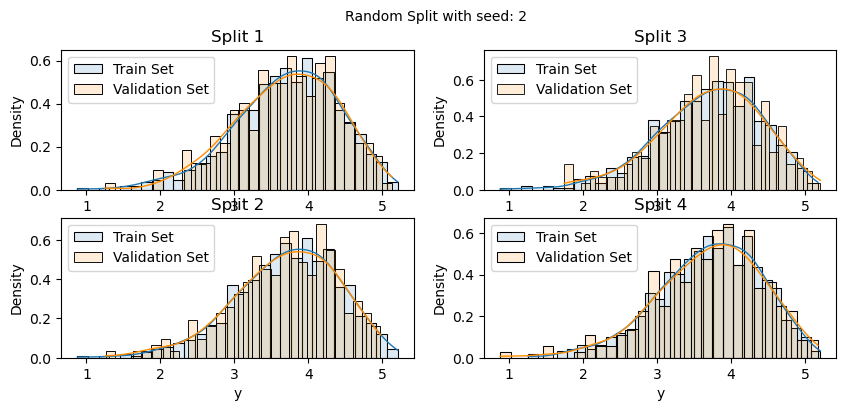

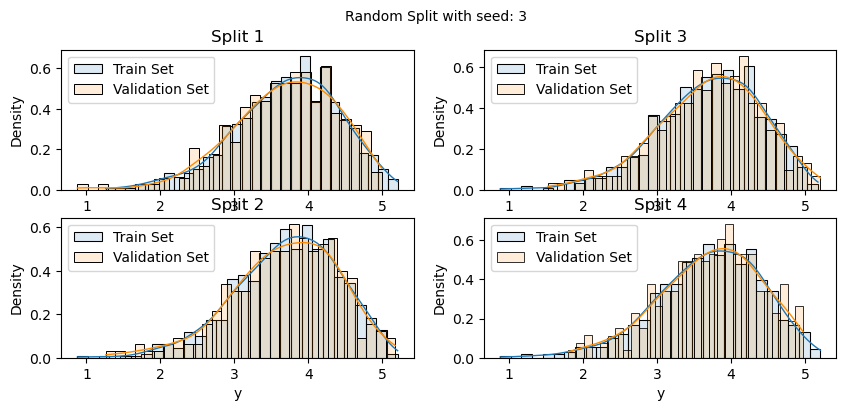

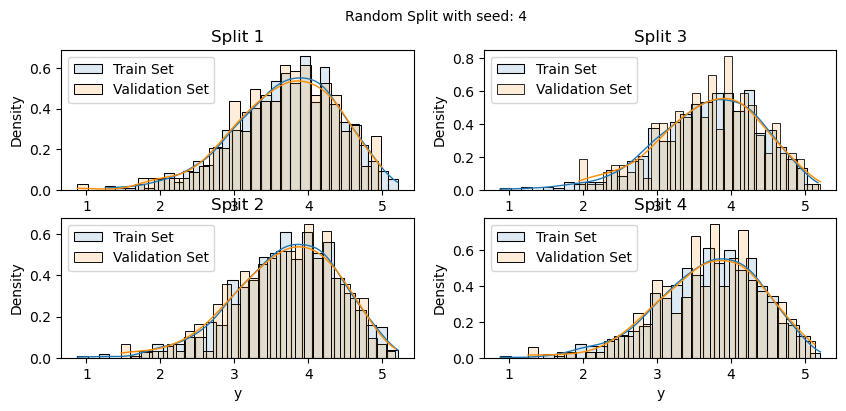

In [41]:
for i in range(5):
    cv_splits = create_cont_folds(y=train.df['y'], n_folds=n_folds, n_groups=n_groups, seed=i)
    fold_visualizer(data=train.df['y'], fold_idxs=cv_splits, seed_num=i)

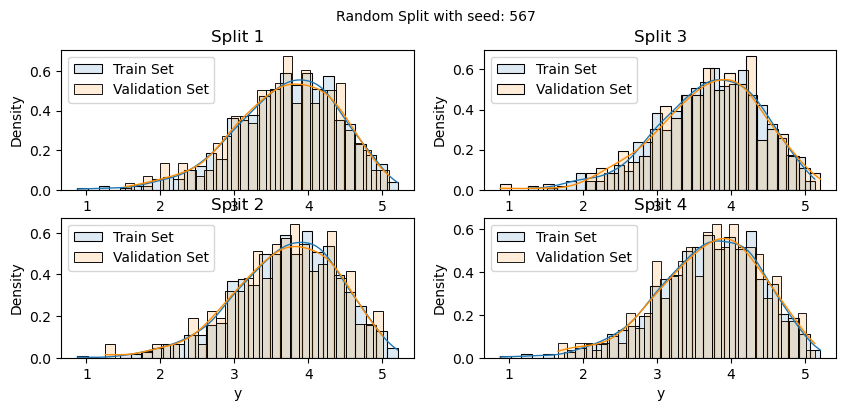

In [34]:
cv_splits = create_cont_folds(y=train.df['y'], n_folds=n_folds, n_groups=n_groups, seed=seed)

fold_visualizer(data=train.df['y'], fold_idxs=cv_splits, seed_num=seed)